# Gathering Data and Cleaning

# Part 1: Importing and Cleaning Data, Creating Features, and Splitting

In [2]:
# Pulling in the dataset and looking at its values
import pandas as pd
dataframe = pd.read_csv("Online Retail.csv")


# Cleaning the data so that we don't have large outliers that skew data
# limit some of the data down and clean it so that we can see values on the graph properly
dataframe = dataframe[dataframe['UnitPrice'] > 0]
dataframe = dataframe[dataframe['Quantity'] > 0]

dataframe = dataframe[dataframe['UnitPrice'] <= 500]
dataframe = dataframe[dataframe['Quantity'] <= 100]

# print(dataframe.head())
# print("***************")
# print(dataframe.info())
# print("***************")
# print(dataframe['Country'].value_counts())

In [3]:
# map the Countries into their own numerical categories called CountryCat
mapping = {"United Kingdom":1, "Germany":2, "France": 3, "EIRE": 4, "Belgium": 5, "Switzerland": 6}
dataframe['CountryCat'] = dataframe['Country'].map(mapping)

# Since the dataset is so large I am going to remove all other countries that we did not categorize
dataframe.dropna(inplace=True)

# create new columns containing individual date pieces from the InvoiceDate
dataframe["InvoiceDate"] = pd.to_datetime(dataframe["InvoiceDate"], format='%Y-%m-%d %H:%M:%S')
dataframe['trans_month'] = dataframe['InvoiceDate'].dt.month
dataframe['trans_week'] = dataframe['InvoiceDate'].dt.isocalendar().week
dataframe["trans_day"] = dataframe['InvoiceDate'].dt.dayofyear

In [4]:
#create a total cost column based on the number of items * the unit price
dataframe['total_cost'] = dataframe['Quantity'] * dataframe['UnitPrice']

# calculate weekly spending average
weekly_cost = []
for i in range(1, 52):
    weekly_cost.append(dataframe[dataframe["trans_week"] == i]["total_cost"].sum())
# add the average weekly total to each row
mapping_dict = dict(zip(range(1, 52), weekly_cost))
dataframe["weekly_total"] = dataframe['trans_week'].map(mapping_dict)

# calculate daily spending average
average_daily_cost = []
for i in range(1, 366):
    average_daily_cost.append(dataframe[dataframe["trans_day"] == i]["total_cost"].mean())
# add the average daily total to each row
mapping_dict = dict(zip(range(1, 366), average_daily_cost))
dataframe["average_daily_total"] = dataframe['trans_day'].map(mapping_dict)

daily_cost = []
for i in range(1, 366):
    daily_cost.append(dataframe[dataframe["trans_day"] == i]["total_cost"].sum())
# add the average daily total to each row
mapping_dict = dict(zip(range(1, 366), daily_cost))
dataframe["daily_total"] = dataframe['trans_day'].map(mapping_dict)

In [5]:
#Get average daily and weekly spending per customer ID.
average_customer = dataframe.groupby('CustomerID')['total_cost'].mean()
total_customer = dataframe.groupby('CustomerID')['total_cost'].sum()

average_customer = average_customer.reset_index()
total_customer = total_customer.reset_index()

average_mapping = dict(zip(average_customer['CustomerID'], average_customer['total_cost']))
total_mapping = dict(zip(total_customer['CustomerID'], total_customer['total_cost']))

dataframe['average_cust_expend'] = dataframe['CustomerID'].map(average_mapping)
dataframe['total_cust_expend'] = dataframe['CustomerID'].map(total_mapping)

array([[<Axes: xlabel='total_cost', ylabel='total_cost'>,
        <Axes: xlabel='average_cust_expend', ylabel='total_cost'>,
        <Axes: xlabel='total_cust_expend', ylabel='total_cost'>,
        <Axes: xlabel='trans_day', ylabel='total_cost'>,
        <Axes: xlabel='daily_total', ylabel='total_cost'>],
       [<Axes: xlabel='total_cost', ylabel='average_cust_expend'>,
        <Axes: xlabel='average_cust_expend', ylabel='average_cust_expend'>,
        <Axes: xlabel='total_cust_expend', ylabel='average_cust_expend'>,
        <Axes: xlabel='trans_day', ylabel='average_cust_expend'>,
        <Axes: xlabel='daily_total', ylabel='average_cust_expend'>],
       [<Axes: xlabel='total_cost', ylabel='total_cust_expend'>,
        <Axes: xlabel='average_cust_expend', ylabel='total_cust_expend'>,
        <Axes: xlabel='total_cust_expend', ylabel='total_cust_expend'>,
        <Axes: xlabel='trans_day', ylabel='total_cust_expend'>,
        <Axes: xlabel='daily_total', ylabel='total_cust_expend'>],

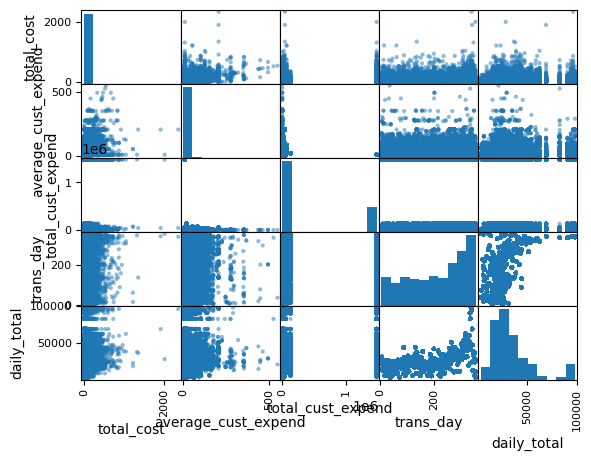

In [34]:
from pandas.plotting import scatter_matrix

compare = ["total_cost", "average_cust_expend", "total_cust_expend", "trans_day", "daily_total"]
scatter_matrix(dataframe[compare])

In [6]:
# Creating training and test sets
from sklearn.model_selection import train_test_split
train, test = train_test_split(dataframe, test_size=0.2, random_state=53)

# Part 2: Choosing features for "X" and a target "y"

__X = train[["average_cust_expend", "total_cust_expend", "total_cost", "Quantity"]]__

__y = train['trans_week']__

When using the Binary Tree classifier I knew that I would need to be predicting a feature that is categorical. I decided to go with the "trans_week" feature.

The overall question I want to ask using these classifiers is can I predict the week of which a transaction/multiple transactions occurred. For example if I knew that someone had spent 500 dollars in a given week on say 10 different items could I predict what time of year in week format that may have been. 

For my X values I knew that I needed information about customer spending, costs of items purchased, and any other money/finacial feature that I had available to me. Thinking through those needs I decided to use "average_cust_expend" (The average expenditure amout for a customer), "total_cust_expend" (The total expenditure amount for a customer over the entire set), "total_cost" (The total cost of each individual transaction) and lastly "Quantity" (The amount of each item that was purchased during a transaction). To me it makes sense that there would be a relation between customer expenditures average and totals, and total cost of each individual transaction. With all that tied into the amount of items bought I hope to see an acceptable correlation.

# Part 3: Creating a Decision Tree and Computing Metrics

In [41]:
from sklearn.tree import DecisionTreeClassifier

X = train[["average_cust_expend", "total_cust_expend", "total_cost", "Quantity"]]
y = train['trans_week']

treec = DecisionTreeClassifier()
treec.fit(X, y)

DecisionTreeClassifier()

In [42]:
Ypred = treec.predict(X)

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
cm = confusion_matrix(y, Ypred)
accuracy = accuracy_score(y, Ypred)
precision = precision_score(y, Ypred, average='weighted')
sensitivity = recall_score(y, Ypred, average='weighted')
f1 = f1_score(y, Ypred, average='weighted')

print("Confusion matrix:")
print(cm)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Sensitivity:", sensitivity)
print("F1 score:", f1)

Confusion matrix:
[[ 3175   179    19 ...  1398    51    12]
 [  124  3101   195 ...  1900    48    11]
 [   54    40  3283 ...  1204    31     1]
 ...
 [  193   264   456 ... 16959   166    44]
 [  111   167    81 ...  2786  3258    19]
 [   68   120    20 ...  1755    92   829]]
Accuracy: 0.5236494345046437
Precision: 0.5991819407909049
Sensitivity: 0.5236494345046437
F1 score: 0.5450970820249603


# Part 4: Decision Tree Comments

When looking at the decision tree outcomes it does look promising! The overall Accuracy was 0.52 which is definitely not bad. One thing that you have to watch out for is that decision trees will overfit terribly if you aren't careful. I tried many other combinations of features besides the ones I picked and I would end up with 99 and 100% accuracy. I think that was due to major overfitting and that some of the datapoints were directly linked/created using the feature being predicted so the correlation was extremely accurate. 

Taking a look at the other scores they are all fairly comparable (around the .5 to .6 range.).  The Precision metric is higher which is good to see. That shows that (if not severely overfitted) the model is slightly better at predicting positive instances.

# Part 5: Using an SVM to try and improve

In [43]:
from sklearn.svm import SVC

# inorder for the SVM to run without taking an extremely long time I randomly chose a 1% selection of the original DF.
# 2 % comes out to 10000 values
SVM_DF = dataframe.sample(frac=0.02)
trainS, testS = train_test_split(SVM_DF, test_size=0.2, random_state=53)

sX = trainS[["average_cust_expend", "total_cust_expend", "total_cost", "Quantity"]]
sy = trainS['trans_week']

svmc = SVC(kernel='poly')
svmc.fit(sX, sy)

Ypred = svmc.predict(sX)
cm = confusion_matrix(sy, Ypred)
accuracy = accuracy_score(sy, Ypred)
precision = precision_score(sy, Ypred, average='weighted')
sensitivity = recall_score(sy, Ypred, average='weighted')
f1 = f1_score(sy, Ypred, average='weighted')

print("Confusion matrix:")
print(cm)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Sensitivity:", sensitivity)
print("F1 score:", f1)

Confusion matrix:
[[  0   0   0 ...  42   0   0]
 [  0   0   0 ...  57   0   0]
 [  0   0   0 ...  65   0   0]
 ...
 [  0   0   0 ... 200   0   0]
 [  0   0   0 ...  65   0   0]
 [  0   0   0 ...  39   0   0]]
Accuracy: 0.06500979431929481
Precision: 0.008855215922532729
Sensitivity: 0.06500979431929481
F1 score: 0.015019353288875844


/Users/parkerc/ds-venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# SVM Comments

SVC classifiers are looking for groups of data that can be uniquely seperated from one another. With the nature of this data there isn't any of this present. That explains the very low scores for the metrics above. 
```
Accuracy: 0.06500979431929481
Precision: 0.008855215922532729
Sensitivity: 0.06500979431929481
F1 score: 0.015019353288875844
```

# Part 6: Use Test Set and Compare Results/Scores

In [44]:
testX = test[["average_cust_expend", "total_cust_expend", "total_cost", "Quantity"]]
testy = test['trans_week']

Ypred = treec.predict(testX)

cm = confusion_matrix(testy, Ypred)
accuracy = accuracy_score(testy, Ypred)
precision = precision_score(testy, Ypred, average='weighted')
sensitivity = recall_score(testy, Ypred, average='weighted')
f1 = f1_score(testy, Ypred, average='weighted')

print("Confusion matrix:")
print(cm)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Sensitivity:", sensitivity)
print("F1 score:", f1)

Confusion matrix:
[[ 485   70   22 ...  399   26    7]
 [  33  463   57 ...  500   26    8]
 [  17   15  511 ...  289    9    4]
 ...
 [  68   81  139 ... 3137   79   17]
 [  34   49   34 ...  736  463   19]
 [  17   30    7 ...  468   27  122]]
Accuracy: 0.3303199772774018
Precision: 0.3730997926143961
Sensitivity: 0.3303199772774018
F1 score: 0.34081648401968134


# Part 7: Parameters Found and Outcomes

After training the model on the training set and then ultimately validating the results on the test set, the outcomes don't look great for the features that I trained the model on. Here are the original values (training set) compared to the test set outcomes. 
```
Accuracy: 0.5236494345046437
Precision: 0.5991819407909049
Sensitivity: 0.5236494345046437
F1 score: 0.5450970820249603

Accuracy: 0.3303199772774018
Precision: 0.3730997926143961
Sensitivity: 0.3303199772774018
F1 score: 0.34081648401968134
```

Its obvious that there is definitely some overfitting occuring here. The training set resulted in 0.52 accuracy while the test set was only able to achieve 0.33. This ultimately means that while there are some predictive power its largely influenced by the original data that we gave it and it doesn't handle foreign data well. The rest of the metrics tell a similar story and ultimately dropped by comparable amounts. For this dataset I don't think a categorical classifier is the correct approach for this data. I believe there is potential for improvement, but it would take more exploration.